In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import numpy as np
from Adam import Adam
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities import *
from utilities import tanh as complex_tanh
import matplotlib.pyplot as plt
import matplotlib as mpl
from plot_lib import plt_set_default, plot_loss
import random
from itertools import cycle



# Fourier Layer 1-D Modified V.1 (Merged Fourier Layers)

In [14]:
# fourier layer

class FourierLayer1d(nn.Module):
    """
    1D Fourier layer
        
    ->input => FFT => multiplied by a (kernel) matrix => inverse FFT => add Wv_t => output
        
    """
    
    def __init__(self, width, modes1):
        super().__init__()
        self.width = width
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (self.width**2))
        self.weights1 = Parameter(self.scale * torch.rand(self.width,
                                                          self.width,
                                                          self.modes1,
                                                          dtype=torch.cfloat))
        
        self.w = nn.Conv1d(self.width, self.width, 1)

    # Complex multiplication
    def compl_mul1d(self, input_, weights):
        """
        (batch, in_channel, resolution), (in_channel, out_channel, resolution) -> (batch, out_channel, resolution)
        
        implemented with the Einstein summation
        values along i-axis are multiplied and summed up
        
        """
        return torch.einsum("bix,iox->box", input_, weights)

    def forward(self, x):
        """
        input size: (batch, in_channel, resolution)
        """
        batch_size, channel_size, resolution = x.size()
        
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        # the first operation in the fourier layer
        # map the input to the fourier domain
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size,
                             self.width,
                             resolution//2 + 1,
                             device=x.device, dtype=torch.cfloat)
        # the reason of out_ft.size(2) = resolution//2 + 1 is because here we are using rfft
        # which takes into account the fact that the DFT of real modes is Hermitian
        # Therefore, only half of the entries needs to be stored.
        # This is also the reason that we are only doing multiplication below once instead of twice
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x1 = torch.fft.irfft(out_ft, n=resolution)
        x2 = self.w(x)
        return x1 + x2

# FNO 1-D Modified V.1 (Residual Fourier Layers)

In [15]:
class FNO1d(nn.Module):
    """
    FNO for 1-d Burger's equation (or parametric differential equations)
    
    It contains 
        1. A fully connected layer that lifts the input to the desire channel dimension
        2. 4 layers of the integral operators u' = (W + K)(u).
           W defined by self.w; K defined by self.conv
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
    input: the value of the initial condition function and spatial parameter (a(x), x)
    input shape: (batchsize, resolution, c=2) 
                  c is the channel size
    output: the solution of a later timestep
    output shape: (batchsize, x=s, c=1) x is the discretization size
    """
    def __init__(self, modes, width):
        super().__init__()
        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = FourierLayer1d(self.width, self.modes1)
        self.conv1 = FourierLayer1d(self.width, self.modes1)
        self.conv2 = FourierLayer1d(self.width, self.modes1)
        self.conv3 = FourierLayer1d(self.width, self.modes1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        """
        input shape: (batch, resolution, 1)
        """
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        # now the shape becomes (batch, resolution, 2)
        
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # now the shape becomes (batch, 2, resolution)
        
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        h1 = self.conv0(x)
        x = F.gelu(h1) + x

        h2 = self.conv1(x)
        x = F.gelu(h2) + x

        h3 = self.conv2(x)
        x = F.gelu(h3) + x

        h4 = self.conv3(x)
        x = h4 + x

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        """
        retrieve the spatial domain
        
        """
        batchsize, resolution = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, resolution), dtype=torch.float)
        gridx = gridx.reshape(1, resolution, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [16]:
# read raw data
file_path = "../data/Burgers/burgers_data_R10.mat"
# file_path = "../data/Burgers/burgers_v100_t100_r1024_N2048.mat"
dataloader = MatReader(file_path)
print(dataloader.data.keys())

# separate input and ground truth
a_data = dataloader.read_field('a')
u_data = dataloader.read_field('u')

sub_train = 2**3
sub_test = 2**2
n_train = 1000
n_test = 200
full_res = a_data.size(-1)
train_res = full_res // sub_train
test_res = full_res // sub_test

# sample data
a_train = a_data[:n_train,::sub_train].reshape(n_train,train_res,1)
u_train = u_data[:n_train,::sub_train]
a_test = a_data[-n_test:,::sub_test].reshape(n_test,test_res,1)
u_test = u_data[-n_test:,::sub_test]
print(a_train.size())
print(a_test.size())

dict_keys(['__header__', '__version__', '__globals__', 'a', 'a_smooth', 'a_smooth_x', 'a_x', 'u'])
torch.Size([1000, 1024, 1])
torch.Size([200, 2048, 1])


In [21]:
# training and testing
%matplotlib notebook

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

###################################################
################## model configs ##################
###################################################

print('training data resolution: ', train_res)
print('testing data resolution: ', test_res)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 20
learning_rate = 0.001
epochs = 500

# for scheduler's use
# learning rate decays by a half for every 50 epochs
step_size = 100
gamma = 0.5

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a_train, u_train), 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a_test, u_test), 
                                          batch_size=20, 
                                          shuffle=False)
modes = 16
width = 64 # size of hidden layers
L = 10 # number of fourier domain convolutions performed
model = FNO1d(modes, width).to(device)
print("count_params(model): ", count_params(model))

optimizer = Adam(model.parameters(), 
                 lr=learning_rate, 
                 weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=step_size, 
                                            gamma=gamma)

myLoss = LpLoss(d=1, p=2, size_average=False) # default is L2 relative error

epoch_step = 25

train_MSE_Loss = []
train_L2_Loss = []
test_L2_Loss = []

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.data.shape)

training data resolution:  1024
testing data resolution:  2048
count_params(model):  549569
fc0.weight 	 torch.Size([64, 2])
fc0.bias 	 torch.Size([64])
conv0.weights1 	 torch.Size([64, 64, 16])
conv0.w.weight 	 torch.Size([64, 64, 1])
conv0.w.bias 	 torch.Size([64])
conv1.weights1 	 torch.Size([64, 64, 16])
conv1.w.weight 	 torch.Size([64, 64, 1])
conv1.w.bias 	 torch.Size([64])
conv2.weights1 	 torch.Size([64, 64, 16])
conv2.w.weight 	 torch.Size([64, 64, 1])
conv2.w.bias 	 torch.Size([64])
conv3.weights1 	 torch.Size([64, 64, 16])
conv3.w.weight 	 torch.Size([64, 64, 1])
conv3.w.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([128, 64])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([1, 128])
fc2.bias 	 torch.Size([1])


<IPython.core.display.Javascript object>


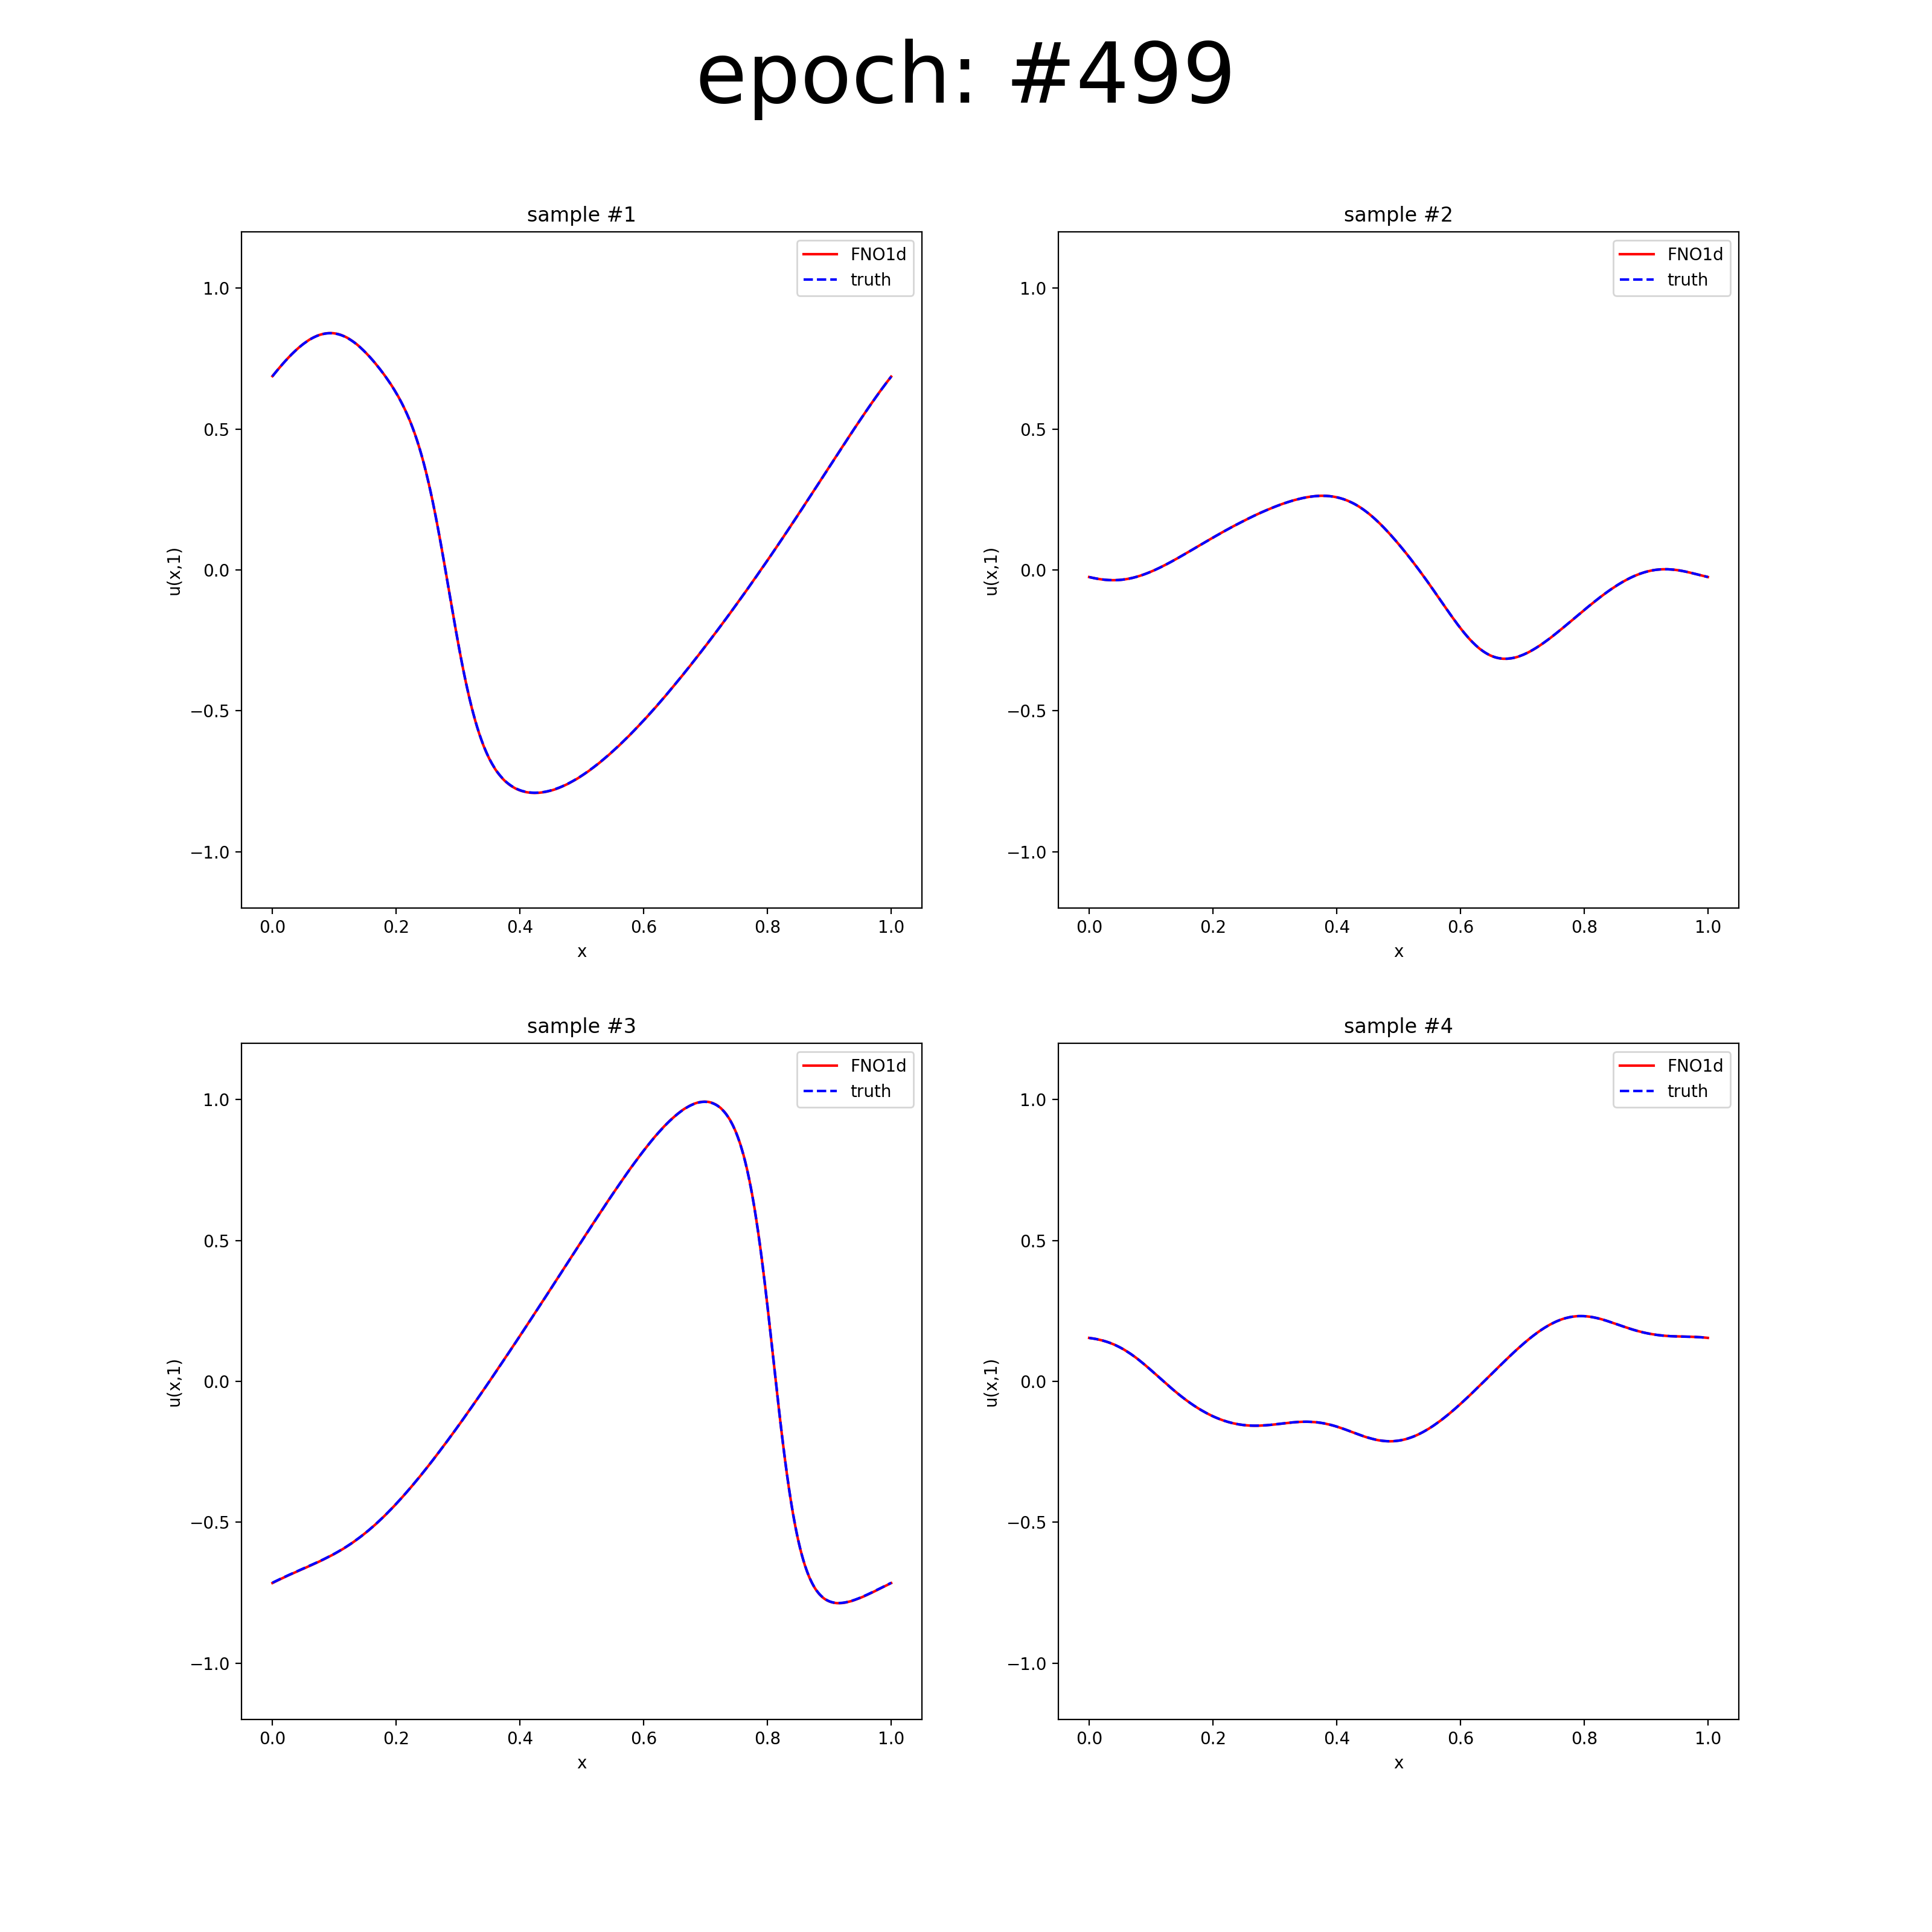

epoch 		 t2-t1 		 train-MSE-Error 	 train-L2-Error 	 test-L2-Error
0		1.96452 		 0.03120		0.26778 	 0.07116


epoch 		 t2-t1 		 train-MSE-Error 	 train-L2-Error 	 test-L2-Error
25		1.93232 		 0.00008		0.01647 	 0.01066


epoch 		 t2-t1 		 train-MSE-Error 	 train-L2-Error 	 test-L2-Error
50		1.93350 		 0.00005		0.01412 	 0.01800


epoch 		 t2-t1 		 train-MSE-Error 	 train-L2-Error 	 test-L2-Error
75		1.93802 		 0.00003		0.01114 	 0.01151


epoch 		 t2-t1 		 train-MSE-Error 	 train-L2-Error 	 test-L2-Error
100		1.91727 		 0.00001		0.00650 	 0.00511


epoch 		 t2-t1 		 train-MSE-Error 	 train-L2-Error 	 test-L2-Error
125		1.93720 		 0.00000		0.00385 	 0.00337


epoch 		 t2-t1 		 train-MSE-Error 	 train-L2-Error 	 test-L2-Error
150		1.90567 		 0.00001		0.00459 	 0.00360


epoch 		 t2-t1 		 train-MSE-Error 	 train-L2-Error 	 test-L2-Error
175		1.92929 		 0.00001		0.00560 	 0.00399


epoch 		 t2-t1 		 train-MSE-Error 	 train-L2-Error 	 test-L2-Error
200		1.91333 		 0.00000		0.00289 	 0.00306

In [22]:
####################################################
################# plotting configs #################
####################################################
torch.autograd.set_detect_anomaly(True)

# change sample by changing rows and cols
rows,cols = 2,2
num_plots = rows * cols

np.random.seed(0)
sampled_batch_idx = random.sample(range(n_test//batch_size),num_plots)
sampled_plotting_idx = np.random.randint(batch_size, size = num_plots)
fig = plt.figure(figsize=(16, 16))

# config for saving figures
saveFig = False
fig_folder = 'ep' + str(epochs) + \
             '-lr' + str(learning_rate) + \
             '-decay' + str(gamma) + \
             '-trainRes' + str(train_res) + \
             '-testRes' + str(test_res)

fig_dir = '../figs/burgers/' + fig_folder
if saveFig:
    if not os.path.isdir(fig_dir):
        os.makedirs(fig_dir)

xvals = np.linspace(0,1,a_data.size(-1))
xvals_test = xvals[::sub_test]
xvals_train = xvals[::sub_train]
plot_pos = 1

for ep in range(epochs):
    fig.clear()
    fig.suptitle('epoch: #' + str(ep),fontsize = 50)
    
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for batch, (a, u) in enumerate(train_loader):
        a, u = a.to(device), u.to(device) 
        # a.shape = (batch, train_res, 1)
        # u.shape = (batch, test_res)
        # the mismatch of dimensions does not matter here because of the reshaping below

        optimizer.zero_grad()
        out = model(a)
        # out.shape = (batch, test_res, 1)

        mse = F.mse_loss(out.view(batch_size, -1), u.view(batch_size, -1), reduction='mean')
        l2 = myLoss(out.view(batch_size, -1), u.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    if (ep % epoch_step)==0 or (ep==(epochs-1)):
        t2 = default_timer()
    
    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for batch, (a, u) in enumerate(test_loader):
            a, u = a.to(device), u.to(device)
            # a.shape = (batch, resolution, 1)
            # u.shape = (batch, resolution)
            
            out = model(a)
            test_l2 += myLoss(out.view(batch_size, -1), u.view(batch_size, -1)).item()
            
            ### plot sampled testing function ###
            
            if batch in sampled_batch_idx:
                idx = sampled_plotting_idx[plot_pos-1]
                ax = fig.add_subplot(rows,cols,plot_pos)
                ax.clear()
#                 ax.get_xaxis().set_visible(False)
                ax.set_ylim((-1.2,1.2))
                u_sample = out[idx,:,:].reshape((-1,1))
                u_sample = u_sample.detach().cpu().numpy()
                u_truth = u[idx,:].reshape((-1,1))
                u_truth = u_truth.detach().cpu().numpy()
                ax.plot(xvals_test, u_sample, 'r', label='FNO1d')
                ax.plot(xvals_test, u_truth, 'b--', label='truth')
                ax.set_title(f"sample #{plot_pos}")
                ax.set_xlabel('x')
                ax.set_ylabel('u(x,1)')
                ax.legend()
                plot_pos += 1
        fig.canvas.draw()
        if saveFig:
            if fig_dir[-1] != '/':
                fig_dir = fig_dir + '/'
            fig_name = fig_dir + 'epoch-' + str(ep) + '.png'
            fig.savefig(fig_name)
        plot_pos = 1

    train_mse /= len(train_loader)
    train_MSE_Loss.append(train_mse)
    
    train_l2 /= n_train
    train_L2_Loss.append(train_l2)
    
    test_l2 /= n_test
    test_L2_Loss.append(test_l2)

    if (ep % epoch_step)==0 or (ep==(epochs-1)):
        print('epoch \t\t t2-t1 \t\t train-MSE-Error \t train-L2-Error \t test-L2-Error')
        print('{0:d}\t\t{1:.5f} \t\t {2:.5f}\t\t{3:.5f} \t {4:.5f}' \
              .format(ep, t2-t1, train_mse, train_l2, test_l2))
        print('\n')
#         print(f'epoch #{ep}')
#         print(f"time since last checked: {t2-t1}")
#         print(f'MSE Training Error: {train_mse}')
#         print(f'Relative L2 Training Error: {train_l2}')
#         print(f'Relative L2 Testing Error: {test_l2}')

# torch.save(model, 'model/ns_fourier_burgers')
pred = torch.zeros(u_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(a_test, u_test), 
                                          batch_size=1, 
                                          shuffle=False)
# with torch.no_grad():
#     for x, y in test_loader:
#         test_l2 = 0
#         x, y = x.to(device), y.to(device)

#         out = model(x).view(-1)
#         pred[index] = out

#         test_l2 += myLoss(out.view(1, -1), y.view(1, -1)).item()
#         print("index, test_l2")
#         print(index, test_l2)
#         index = index + 1
print('FINISHED!')

<IPython.core.display.Javascript object>


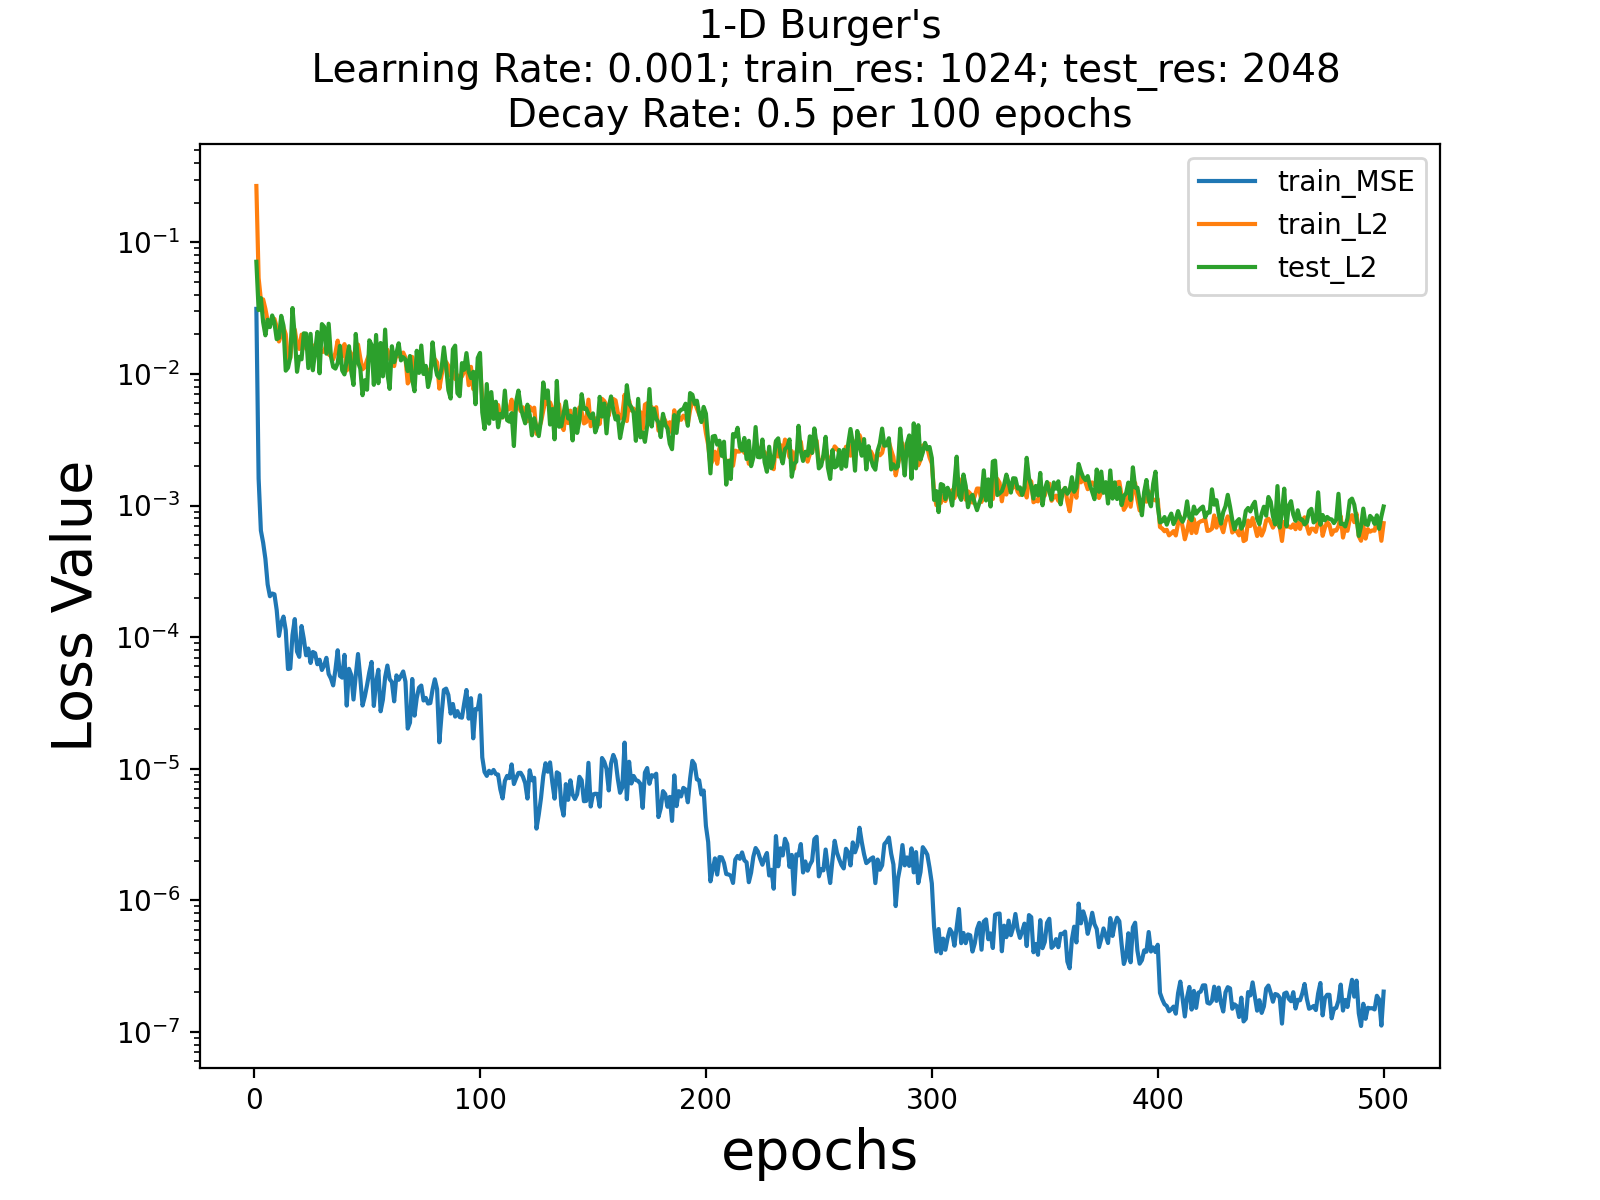

0.0005881419568322599


In [26]:
savefig = True
figpath = '../figs/burgers/loss/'
figname = 'resFNO' + \
          'ep' + str(epochs) + \
          '-lr' + "".join(str(learning_rate).split('.')) + \
          '-decay' + "".join(str(gamma).split('.')) + \
          '-trainRes' + str(train_res) + \
          '-testRes' + str(test_res)

figtitle = 'Residual FNO \n 1-D Burger\'s \n Learning Rate: ' + str(learning_rate) + \
           '; train_res: ' + str(train_res) + '; test_res: ' + str(test_res) + '\n' + \
           'Decay Rate: ' + str(gamma) + ' per ' + str(step_size) + ' epochs'
plot_loss(figtitle = figtitle,
          figpath = figpath, 
          figname = figname,
          savefig = savefig, 
          train_MSE = train_MSE_Loss, 
          train_L2 = train_L2_Loss, 
          test_L2 = test_L2_Loss)
print(min(test_L2_Loss))